For infant cry detection, can use various machine learning models to train the classifier. 

1. **Random Forest Classifier:** Random Forest is an ensemble learning method that can work well for classification tasks. It can handle both numerical and categorical features and is robust against overfitting.

2. **Support Vector Machine (SVM):** SVM is a powerful classifier that can be effective in binary classification tasks like cry detection. It tries to find the hyperplane that best separates the two classes.

3. **Logistic Regression:** Logistic regression is a simple yet effective model for binary classification. It's easy to interpret and can serve as a baseline model.

4. **K-Nearest Neighbors (K-NN):** K-NN is a non-parametric algorithm that classifies an instance based on the majority class among its k-nearest neighbors. It's easy to understand and can work well with appropriate distance metrics.

5. **Gradient Boosting (e.g., XGBoost, LightGBM):** Gradient boosting algorithms can provide high accuracy and can handle complex relationships in the data. They are particularly useful when dealing with imbalanced datasets.

6. **Neural Networks:** Deep learning models, such as convolutional neural networks (CNNs) or recurrent neural networks (RNNs), can be employed for audio-based classification tasks like cry detection. They require a larger amount of data and computational resources but can achieve state-of-the-art performance.

7. **Naive Bayes:** Naive Bayes classifiers are simple probabilistic models that can be suitable for text-based cry detection when text features are used.

8. **Ensemble Methods:** You can create an ensemble of different classifiers to improve overall performance. For example, you can combine the predictions of multiple models like Random Forest, SVM, and Logistic Regression.

9. **Hidden Markov Models (HMMs):** HMMs are commonly used for time-series data and speech recognition. They can be adapted for audio-based cry detection.

The choice of model depends on the complexity of  dataset, the quality of  features, and computational resources. Additionally, consider using techniques like feature engineering, hyperparameter tuning, and cross-validation to optimize model's performance.


In [122]:
from scipy.io.wavfile import read
import scipy.signal as signal
import matplotlib as mpl
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import numpy as np

cmap = mpl.colormaps['Reds']


In [3]:

sampling_rate,data= read(r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\301 - Crying baby\margot.m4a_11.wav")

In [4]:
print(data.shape)

(220500,)


In [5]:
wav=data[:,]

In [6]:
print(type(wav))

<class 'numpy.ndarray'>


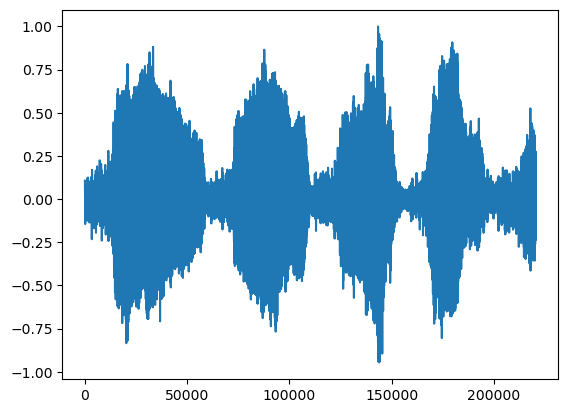

In [7]:
plt.plot(wav)
plt.show()

In [8]:
f, t, Zxx = signal.stft(wav, fs=sampling_rate)

In [9]:
print(f.shape)

(129,)


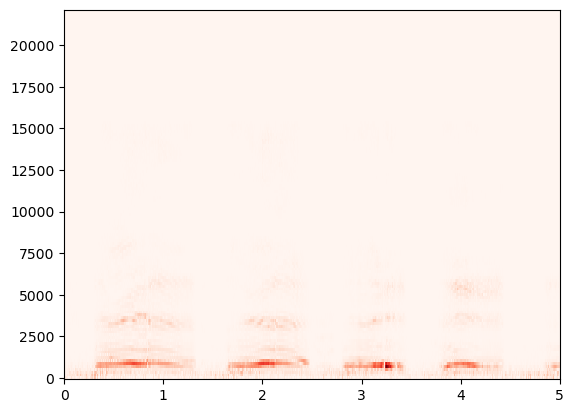

In [10]:
plt.pcolormesh(t, f, np.abs(Zxx), cmap=cmap)

In [3]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import skew, kurtosis
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier


In [4]:
# Directory containing the infant cry audio files
data_dir_cry = r"D:\infant cry detecting\dev\V1\donateacry_corpus_cleaned_and_updated_data\New folder"
# List all files in the directory
audio_files_cry = os.listdir(data_dir_cry)

In [5]:
# Directory containing the infant non-cry audio files
data_dir_non_cry = r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\901 - Silence"

# List all files in the directory
audio_files_non_cry = os.listdir(data_dir_non_cry)

In [191]:
# Sample rate and other parameters
fs = 1000  # Sample rate 
nperseg = 256  # Window size for STFT 
noverlap = 128  # Overlap between windows 

# Initialize empty lists for features
features = []
labels = []
# Initialize empty lists for features and labels
X = []
y = []

In [192]:
# Function to extract features from an audio file
def extract_features(audio_path, is_cry):
    # Read the audio file
    fs, audio_signal = wavfile.read(audio_path)

    # Compute STFT
    f, t, Sxx = spectrogram(audio_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Calculate the 20 features from STFT
    tf_mean = np.mean(Sxx)
    tf_std = np.std(Sxx)
    
    tma = np.max(Sxx, axis=0)
    tma_max = np.max(tma)
    tma_min = np.min(tma)
    tma_mean = np.mean(tma)
    tma_std = np.std(tma)
    tma_skewness = skew(tma)
    tma_kurt = kurtosis(tma)
        
    fma = np.max(Sxx, axis=1)
    fma_max = np.max(fma)
    fma_min = np.min(fma)
    fma_mean = np.mean(fma)
    fma_std = np.std(fma)
    fma_skewness = skew(fma)
    fma_kurt = kurtosis(fma)
        
    fsda = np.std(Sxx, axis=1)
    fsda_max = np.max(fsda)
    fsda_min = np.min(fsda)
    fsda_mean = np.mean(fsda)
    fsda_std = np.std(fsda)
    fsda_skewness = skew(fsda)
    fsda_kurt = kurtosis(fsda)

    # Combine features into a feature vector
    feature_vector = np.array([is_cry, tf_mean, tf_std,
                               tma_max, tma_min, tma_mean, tma_std, tma_skewness, tma_kurt,
                               fma_max, fma_min, fma_mean, fma_std, fma_skewness, fma_kurt, 
                               fsda_max, fsda_min, fsda_mean, fsda_std, fsda_skewness, fsda_kurt])

    return feature_vector


In [193]:
#Loop through each cry audio file
for audio_file in os.listdir(data_dir_cry):
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(data_dir_cry, audio_file)
        feature_vector = extract_features(audio_path, is_cry=1)
        features.append(feature_vector)
        labels.append(1)  # Label 1 for cry

In [194]:
#Loop through each non-cry audio file
for audio_file in os.listdir(data_dir_non_cry):
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(data_dir_non_cry, audio_file)
        feature_vector = extract_features(audio_path, is_cry=0)
        features.append(feature_vector)
        labels.append(0)  # Label 0 for non-cry


In [195]:
# Create a DataFrame with the extracted features
column_names = ['is_ cry','TF_Mean', 'TF_Std', 'TMA_Max', 'TMA_Min', 'TMA_Mean', 'TMA_Std', 'TMA_Skewness', 'TMA_Kurtosis',
                'FMA_Max', 'FMA_Min', 'FMA_Mean', 'FMA_Std', 'FMA_Skewness', 'FMA_Kurtosis',
                'FSDA_Max', 'FSDA_Min', 'FSDA_Mean', 'FSDA_Std', 'FSDA_Skewness', 'FSDA_Kurtosis']


In [217]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.DataFrame(features, columns=column_names)


# Split the data into features (X) and labels (y)
X = df.drop('is_ cry', axis=1)
y = df['is_ cry']

# Handle missing values in X using SimpleImputer (replace NaNs with the mean of each feature)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
# Drop rows with missing values
#df.dropna(inplace=True)





In [218]:
# Drop rows with missing values
df.dropna(inplace=True)

In [219]:
# Convert the target variable to integers (0 for non-cry, 1 for cry)
y = y.astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [220]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [221]:
# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# Evaluate the model

report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.96      0.98        28

    accuracy                           0.98        52
   macro avg       0.98      0.98      0.98        52
weighted avg       0.98      0.98      0.98        52



In [222]:
# Example: Classify a new audio clip
new_audio_path = r"D:\infant cry detecting\dev\V1\donateacry_corpus_cleaned_and_updated_data\New folder\4cefc13c-e7c0-4b5a-bddb-c40c103e640a-1431583459308-1.7-f-26-hu.wav"

is_cry_label = 1

new_feature_vector = extract_features(new_audio_path, is_cry_label)

# Remove the last feature from the new_feature_vector
new_feature_vector = new_feature_vector[:-1]

prediction = rf_classifier.predict([new_feature_vector])

if prediction[0] == 1:
    print("The new audio clip contains a cry sound.")
else:
    print("The new audio clip does not contain a cry sound.")



The new audio clip contains a cry sound.


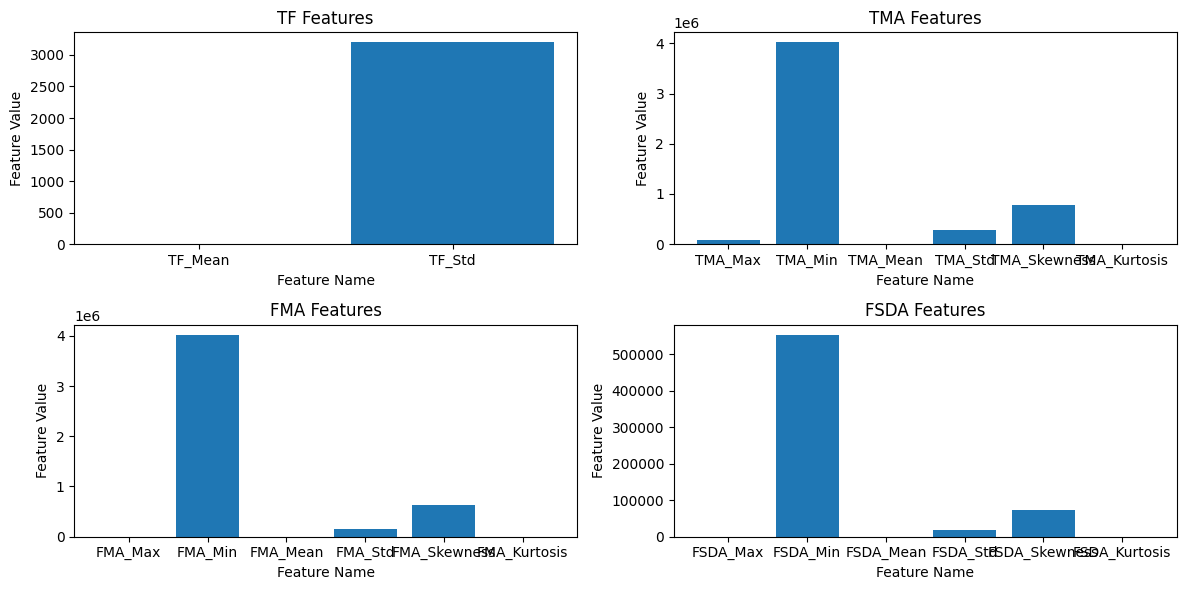

TF Set Features:
TF_Mean: 1.0
TF_Std: 3199.064208984375
TMA Set Features:
TMA_Max: 76237.828125
TMA_Min: 4020494.75
TMA_Mean: 3.131982884951867e-05
TMA_Std: 274103.5625
TMA_Skewness: 785793.25
TMA_Kurtosis: 3.1155098842168054
FMA Set Features:
FMA_Max: 8.893579722698158
FMA_Min: 4020494.75
FMA_Mean: 4.6889729499816895
FMA_Std: 157513.671875
FMA_Skewness: 635159.0625
FMA_Kurtosis: 4.850776588205979
FSDA Set Features:
FSDA_Max: 22.865075141967058
FSDA_Min: 552650.25
FSDA_Mean: 0.3931979835033417
FSDA_Std: 16712.982421875
FSDA_Skewness: 72954.3359375
FSDA_Kurtosis: 5.613559454563936


In [266]:
import matplotlib.pyplot as plt

# Extracted feature names
feature_names = [
    'TF_Mean', 'TF_Std',
    'TMA_Max', 'TMA_Min', 'TMA_Mean', 'TMA_Std', 'TMA_Skewness', 'TMA_Kurtosis',
    'FMA_Max', 'FMA_Min', 'FMA_Mean', 'FMA_Std', 'FMA_Skewness', 'FMA_Kurtosis',
    'FSDA_Max', 'FSDA_Min', 'FSDA_Mean', 'FSDA_Std', 'FSDA_Skewness', 'FSDA_Kurtosis'
]

# Extract the TF set features
tf_features = new_feature_vector[0:2]

# Extract the TMA set features
tma_features = new_feature_vector[2:8]

# Extract the FMA set features
fma_features = new_feature_vector[8:14]

# Extract the FSDA set features
fsda_features = new_feature_vector[14:]

# Plotting the values of TF set features
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.bar(['TF_Mean', 'TF_Std'], tf_features)
plt.title('TF Features')
plt.xlabel('Feature Name')
plt.ylabel('Feature Value')

# Plotting the values of TMA set features
plt.subplot(2, 2, 2)
plt.bar(['TMA_Max', 'TMA_Min', 'TMA_Mean', 'TMA_Std', 'TMA_Skewness', 'TMA_Kurtosis'], tma_features)
plt.title('TMA Features')
plt.xlabel('Feature Name')
plt.ylabel('Feature Value')

# Plotting the values of FMA set features
plt.subplot(2, 2, 3)
plt.bar(['FMA_Max', 'FMA_Min', 'FMA_Mean', 'FMA_Std', 'FMA_Skewness', 'FMA_Kurtosis'], fma_features)
plt.title('FMA Features')
plt.xlabel('Feature Name')
plt.ylabel('Feature Value')

# Plotting the values of FSDA set features
plt.subplot(2, 2, 4)
plt.bar(['FSDA_Max', 'FSDA_Min', 'FSDA_Mean', 'FSDA_Std', 'FSDA_Skewness', 'FSDA_Kurtosis'], fsda_features)
plt.title('FSDA Features')
plt.xlabel('Feature Name')
plt.ylabel('Feature Value')

plt.tight_layout()
plt.show()

# Printing the values of TF set features
print("TF Set Features:")
for feature_name, feature_value in zip(['TF_Mean', 'TF_Std'], tf_features):
    print(f"{feature_name}: {feature_value}")

# Printing the values of TMA set features
print("TMA Set Features:")
for feature_name, feature_value in zip(['TMA_Max', 'TMA_Min', 'TMA_Mean', 'TMA_Std', 'TMA_Skewness', 'TMA_Kurtosis'], tma_features):
    print(f"{feature_name}: {feature_value}")

# Printing the values of FMA set features
print("FMA Set Features:")
for feature_name, feature_value in zip(['FMA_Max', 'FMA_Min', 'FMA_Mean', 'FMA_Std', 'FMA_Skewness', 'FMA_Kurtosis'], fma_features):
    print(f"{feature_name}: {feature_value}")

# Printing the values of FSDA set features
print("FSDA Set Features:")
for feature_name, feature_value in zip(['FSDA_Max', 'FSDA_Min', 'FSDA_Mean', 'FSDA_Std', 'FSDA_Skewness', 'FSDA_Kurtosis'], fsda_features):
    print(f"{feature_name}: {feature_value}")


new_audio_path = r"D:\infant cry detecting\dev\V1\donateacry_corpus_cleaned_and_updated_data\New folder\4cefc13c-e7c0-4b5a-bddb-c40c103e640a-1431583459308-1.7-f-26-hu.wav"

new_feature_vector = extract_features(new_audio_path,  is_cry = None)
prediction = clf.predict([new_feature_vector])

if prediction[0] == 1:
    print("The new audio clip contains a cry sound.")
else:
    print("The new audio clip does not contain a cry sound.")

In [223]:
# Initialize and train a Random Forest Classifier
#clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf.fit(X_train, y_train)
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)


HistGradientBoostingClassifier(random_state=42)

In [224]:
# Make predictions on the test set
y_pred = clf.predict(X_test)


In [225]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


In [226]:
print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.9807692307692307
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.96      0.98        28

    accuracy                           0.98        52
   macro avg       0.98      0.98      0.98        52
weighted avg       0.98      0.98      0.98        52



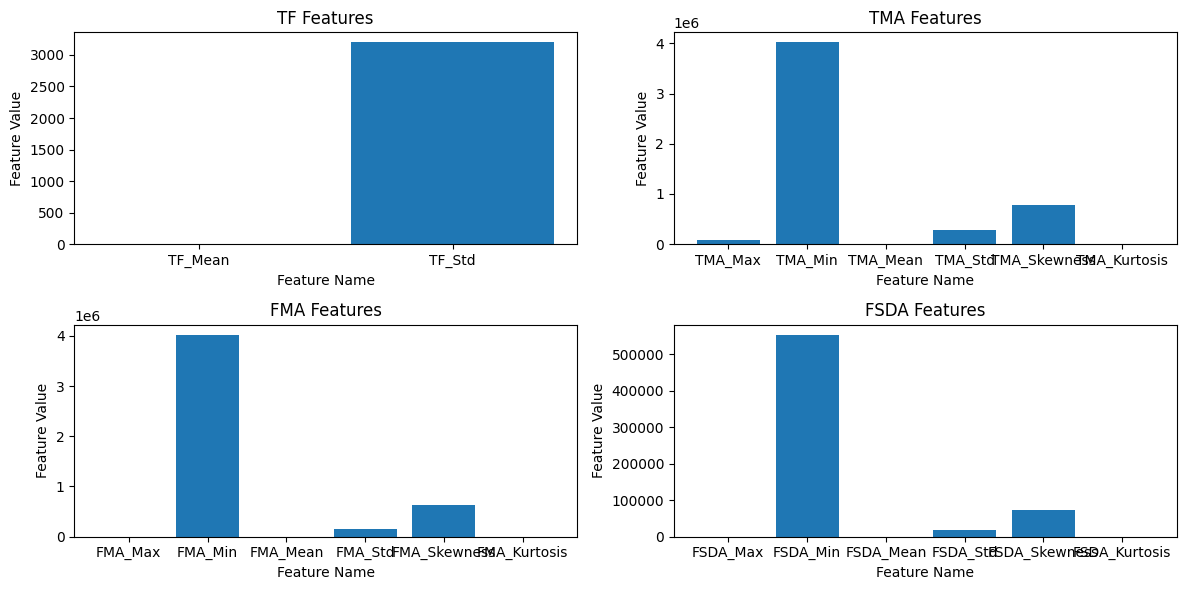

TF Set Features:
TF_Mean: 1.0
TF_Std: 3199.064208984375
TMA Set Features:
TMA_Max: 76237.828125
TMA_Min: 4020494.75
TMA_Mean: 3.131982884951867e-05
TMA_Std: 274103.5625
TMA_Skewness: 785793.25
TMA_Kurtosis: 3.1155098842168054
FMA Set Features:
FMA_Max: 8.893579722698158
FMA_Min: 4020494.75
FMA_Mean: 4.6889729499816895
FMA_Std: 157513.671875
FMA_Skewness: 635159.0625
FMA_Kurtosis: 4.850776588205979
FSDA Set Features:
FSDA_Max: 22.865075141967058
FSDA_Min: 552650.25
FSDA_Mean: 0.3931979835033417
FSDA_Std: 16712.982421875
FSDA_Skewness: 72954.3359375
FSDA_Kurtosis: 5.613559454563936


In [265]:
import matplotlib.pyplot as plt

# Extracted feature names
feature_names = [
    'TF_Mean', 'TF_Std',
    'TMA_Max', 'TMA_Min', 'TMA_Mean', 'TMA_Std', 'TMA_Skewness', 'TMA_Kurtosis',
    'FMA_Max', 'FMA_Min', 'FMA_Mean', 'FMA_Std', 'FMA_Skewness', 'FMA_Kurtosis',
    'FSDA_Max', 'FSDA_Min', 'FSDA_Mean', 'FSDA_Std', 'FSDA_Skewness', 'FSDA_Kurtosis'
]

# Extract the TF set features
tf_features = new_feature_vector[0:2]

# Extract the TMA set features
tma_features = new_feature_vector[2:8]

# Extract the FMA set features
fma_features = new_feature_vector[8:14]

# Extract the FSDA set features
fsda_features = new_feature_vector[14:]

# Plotting the values of TF set features
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.bar(['TF_Mean', 'TF_Std'], tf_features)
plt.title('TF Features')
plt.xlabel('Feature Name')
plt.ylabel('Feature Value')

# Plotting the values of TMA set features
plt.subplot(2, 2, 2)
plt.bar(['TMA_Max', 'TMA_Min', 'TMA_Mean', 'TMA_Std', 'TMA_Skewness', 'TMA_Kurtosis'], tma_features)
plt.title('TMA Features')
plt.xlabel('Feature Name')
plt.ylabel('Feature Value')

# Plotting the values of FMA set features
plt.subplot(2, 2, 3)
plt.bar(['FMA_Max', 'FMA_Min', 'FMA_Mean', 'FMA_Std', 'FMA_Skewness', 'FMA_Kurtosis'], fma_features)
plt.title('FMA Features')
plt.xlabel('Feature Name')
plt.ylabel('Feature Value')

# Plotting the values of FSDA set features
plt.subplot(2, 2, 4)
plt.bar(['FSDA_Max', 'FSDA_Min', 'FSDA_Mean', 'FSDA_Std', 'FSDA_Skewness', 'FSDA_Kurtosis'], fsda_features)
plt.title('FSDA Features')
plt.xlabel('Feature Name')
plt.ylabel('Feature Value')

plt.tight_layout()
plt.show()

# Printing the values of TF set features
print("TF Set Features:")
for feature_name, feature_value in zip(['TF_Mean', 'TF_Std'], tf_features):
    print(f"{feature_name}: {feature_value}")

# Printing the values of TMA set features
print("TMA Set Features:")
for feature_name, feature_value in zip(['TMA_Max', 'TMA_Min', 'TMA_Mean', 'TMA_Std', 'TMA_Skewness', 'TMA_Kurtosis'], tma_features):
    print(f"{feature_name}: {feature_value}")

# Printing the values of FMA set features
print("FMA Set Features:")
for feature_name, feature_value in zip(['FMA_Max', 'FMA_Min', 'FMA_Mean', 'FMA_Std', 'FMA_Skewness', 'FMA_Kurtosis'], fma_features):
    print(f"{feature_name}: {feature_value}")

# Printing the values of FSDA set features
print("FSDA Set Features:")
for feature_name, feature_value in zip(['FSDA_Max', 'FSDA_Min', 'FSDA_Mean', 'FSDA_Std', 'FSDA_Skewness', 'FSDA_Kurtosis'], fsda_features):
    print(f"{feature_name}: {feature_value}")


In [227]:
# Example: Classify a new audio clip
new_audio_path = r"D:\infant cry detecting\dev\V1\donateacry_corpus_cleaned_and_updated_data\New folder\4cefc13c-e7c0-4b5a-bddb-c40c103e640a-1431583459308-1.7-f-26-hu.wav"

is_cry_label = 1

new_feature_vector = extract_features(new_audio_path, is_cry_label)

# Remove the last feature from the new_feature_vector
new_feature_vector = new_feature_vector[:-1]

prediction = rf_classifier.predict([new_feature_vector])

if prediction[0] == 1:
    print("The new audio clip contains a cry sound.")
else:
    print("The new audio clip does not contain a cry sound.")



The new audio clip contains a cry sound.


In [228]:
# Folder containing the audio clips you want to classify
folder_path = r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\New folder"

# List all audio files in the folder
audio_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

# Classify each audio clip in the folder
for audio_file in audio_files:
    # Get the full path to the audio file
    audio_path = os.path.join(folder_path, audio_file)

    is_cry_label = 1

    new_feature_vector = extract_features(audio_path, is_cry_label)

    new_feature_vector = new_feature_vector[:-1]

    # Make a prediction using the trained model (rf_classifier)
    prediction = rf_classifier.predict([new_feature_vector])

    # Interpret the prediction
    if prediction[0] == 1:
        print(f"'{audio_file}' - a cry sound.")
    else:
        print(f"'{audio_file}' - not a cry sound.")


'Louise_01.m4a_0.wav' - not a cry sound.
'Louise_01.m4a_1.wav' - not a cry sound.
'Louise_01.m4a_10.wav' - not a cry sound.
'Louise_01.m4a_11.wav' - not a cry sound.
'Louise_01.m4a_12.wav' - not a cry sound.
'Louise_01.m4a_13.wav' - not a cry sound.
'Louise_01.m4a_14.wav' - not a cry sound.
'Louise_01.m4a_2.wav' - not a cry sound.
'Louise_01.m4a_3.wav' - not a cry sound.
'Louise_01.m4a_4.wav' - not a cry sound.
'Louise_01.m4a_5.wav' - not a cry sound.
'Louise_01.m4a_6.wav' - not a cry sound.
'Louise_01.m4a_7.wav' - not a cry sound.
'Louise_01.m4a_8.wav' - not a cry sound.
'Louise_01.m4a_9.wav' - not a cry sound.
'margot.m4a_0.wav' - not a cry sound.
'margot.m4a_1.wav' - not a cry sound.
'margot.m4a_10.wav' - not a cry sound.
'margot.m4a_11.wav' - not a cry sound.
'margot.m4a_12.wav' - not a cry sound.
'margot.m4a_13.wav' - not a cry sound.
'margot.m4a_14.wav' - not a cry sound.
'margot.m4a_15.wav' - not a cry sound.
'margot.m4a_16.wav' - not a cry sound.
'margot.m4a_17.wav' - not a cry

folder_path = r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\New folder"

audio_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

for audio_file in audio_files:
    # Get the full path to the audio file
    audio_path = os.path.join(folder_path, audio_file)

    # Extract features from the audio clip
    new_feature_vector = extract_features(audio_path, is_cry = None)

    # Make a prediction using the trained model
    prediction = clf.predict([new_feature_vector])

    # Interpret the prediction
    if prediction[0] == 1:
        print(f" '{audio_file}' - a cry sound.")
    else:
        print(f"'{audio_file}' - not a cry sound.")

In [229]:
import sklearn
from sklearn.metrics import confusion_matrix

In [230]:
from sklearn.model_selection import GridSearchCV

In [231]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[24,  0],
       [ 1, 27]], dtype=int64)

Train a Support Vector Machine (SVM) Classifier

In [232]:
from sklearn.impute import SimpleImputer  # Import SimpleImputer for handling missing values
from sklearn.svm import SVC


In [233]:
# Initialize and train a Support Vector Machine (SVM) Classifier
clf = SVC(kernel='linear', C=1.0, random_state=42)

# Convert the target variable to integers (0 for non-cry, 1 for cry)
y = y.astype(int)

clf.fit(X_train, y_train)


SVC(kernel='linear', random_state=42)

In [234]:
# Now, you can use X_test_df for prediction
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)



Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        28

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



Logistic Regression

In [235]:
from sklearn.linear_model import LogisticRegression

In [236]:
# Make predictions on the test set
y_pred = clf.predict(X)

# Evaluate the model (this is for training evaluation; you should split your data for proper evaluation)
accuracy = accuracy_score(y, y_pred)
report = classification_report(y, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)



Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00       149

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257



In [238]:
# Example: Classify a new audio clip
new_audio_path = r"D:\infant cry detecting\dev\V1\donateacry_corpus_cleaned_and_updated_data\New folder\4cefc13c-e7c0-4b5a-bddb-c40c103e640a-1431583459308-1.7-f-26-hu.wav"

is_cry_label = 1

new_feature_vector = extract_features(new_audio_path, is_cry_label)

# Remove the last feature from the new_feature_vector
new_feature_vector = new_feature_vector[:-1]

prediction = rf_classifier.predict([new_feature_vector])

if prediction[0] == 1:
    print("The new audio clip contains a cry sound.")
else:
    print("The new audio clip does not contain a cry sound.")


The new audio clip contains a cry sound.


K-Nearest Neighbors (K-NN)

In [239]:
from sklearn.neighbors import KNeighborsClassifier 

In [240]:
# Ensure X is in a suitable format (NumPy array)
X = np.array(X)

# Check if X is C-contiguous
if not X.flags.c_contiguous:
    # If not C-contiguous, create a new C-contiguous array and copy the data
    X = np.ascontiguousarray(X)

In [241]:
# Initialize and train a K-Nearest Neighbors (K-NN) Classifier
clf = KNeighborsClassifier(n_neighbors=3)  # can adjust the number of neighbors as needed
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [242]:
# Make predictions on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9615384615384616
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       1.00      0.93      0.96        28

    accuracy                           0.96        52
   macro avg       0.96      0.96      0.96        52
weighted avg       0.96      0.96      0.96        52



In [243]:
# Example: Classify a new audio clip
new_audio_path = r"D:\infant cry detecting\dev\V1\donateacry_corpus_cleaned_and_updated_data\New folder\4cefc13c-e7c0-4b5a-bddb-c40c103e640a-1431583459308-1.7-f-26-hu.wav"

is_cry_label = 1

new_feature_vector = extract_features(new_audio_path, is_cry_label)

# Remove the last feature from the new_feature_vector
new_feature_vector = new_feature_vector[:-1]

prediction = rf_classifier.predict([new_feature_vector])

if prediction[0] == 1:
    print("The new audio clip contains a cry sound.")
else:
    print("The new audio clip does not contain a cry sound.")


The new audio clip contains a cry sound.


Gradient Boosting (e.g., XGBoost)

In [244]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42)

# Train the model
xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.9807692307692307
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.96      0.98        28

    accuracy                           0.98        52
   macro avg       0.98      0.98      0.98        52
weighted avg       0.98      0.98      0.98        52



C:\Users\Admin\anaconda3\envs\cry_det\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [245]:
import xgboost as xgb

In [246]:
# Initialize and train an XGBoost Classifier
clf = xgb.XGBClassifier(random_state=42)
clf.fit(X_train, y_train)



C:\Users\Admin\anaconda3\envs\cry_det\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [247]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9807692307692307
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.96      0.98        28

    accuracy                           0.98        52
   macro avg       0.98      0.98      0.98        52
weighted avg       0.98      0.98      0.98        52



In [249]:
# Example: Classify a new audio clip
new_audio_path = r"D:\infant cry detecting\dev\V1\donateacry_corpus_cleaned_and_updated_data\New folder\4cefc13c-e7c0-4b5a-bddb-c40c103e640a-1431583459308-1.7-f-26-hu.wav"

is_cry_label = 1

new_feature_vector = extract_features(new_audio_path, is_cry_label)

# Remove the last feature from the new_feature_vector
new_feature_vector = new_feature_vector[:-1]

prediction = rf_classifier.predict([new_feature_vector])

if prediction[0] == 1:
    print("The new audio clip contains a cry sound.")
else:
    print("The new audio clip does not contain a cry sound.")



The new audio clip contains a cry sound.


Neural Networks

In [250]:
import tensorflow as tf
from tensorflow import keras

In [251]:

# Build a neural network model
model = keras.Sequential([
    keras.layers.Input(20),  # Input layer with the number of features
    keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 units and ReLU activation
    keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 units and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10,batch_size=32, validation_split=0.2)




Epoch 1/10
6/6 [==============================] - 3s 99ms/step - loss: 185097.0469 - accuracy: 0.0061 - val_loss: 0.3770 - val_accuracy: 0.8780
Epoch 2/10
6/6 [==============================] - 0s 25ms/step - loss: 0.1968 - accuracy: 0.9085 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 0s 23ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 1.0978e-04 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 0s 22ms/step - loss: 5.2218e-04 - accuracy: 1.0000 - val_loss: 1.0742e-05 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 0s 22ms/step - loss: 9.1846e-05 - accuracy: 1.0000 - val_loss: 2.8772e-06 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 0s 21ms/step - loss: 3.6060e-05 - accuracy: 1.0000 - val_loss: 1.3515e-06 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 0s 22ms/step - loss: 2.0937e-05 - accuracy: 1.0000 - val_loss: 8.7734e-07 - val_acc

In [252]:
# Evaluate the model on the test set
accuracy = model.evaluate(X_test, y_test)[1]
print("Test Accuracy:", accuracy)



2/2 [==============================] - 0s 12ms/step - loss: 4.6421e-09 - accuracy: 1.0000
Test Accuracy: 1.0


In [253]:
# Compile the model (you've already done this)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
6/6 [==============================] - 3s 96ms/step - loss: 6.5064e-07 - accuracy: 1.0000 - val_loss: 5.1138e-12 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 0s 23ms/step - loss: 4.4714e-11 - accuracy: 1.0000 - val_loss: 2.1752e-14 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 0s 22ms/step - loss: 1.0772e-12 - accuracy: 1.0000 - val_loss: 1.2225e-15 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 0s 23ms/step - loss: 1.1130e-13 - accuracy: 1.0000 - val_loss: 2.4356e-16 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 0s 21ms/step - loss: 4.5753e-14 - accuracy: 1.0000 - val_loss: 9.7532e-17 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 0s 20ms/step - loss: 1.9631e-14 - accuracy: 1.0000 - val_loss: 5.7802e-17 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 0s 20ms/step - loss: 1.4168e-14 - accuracy: 1.0000 - val_loss: 4.290

In [254]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9807692307692307
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.96      0.98        28

    accuracy                           0.98        52
   macro avg       0.98      0.98      0.98        52
weighted avg       0.98      0.98      0.98        52



In [255]:
# Example: Classify a new audio clip
new_audio_path = r"D:\infant cry detecting\dev\V1\donateacry_corpus_cleaned_and_updated_data\New folder\4cefc13c-e7c0-4b5a-bddb-c40c103e640a-1431583459308-1.7-f-26-hu.wav"

is_cry_label = 1

new_feature_vector = extract_features(new_audio_path, is_cry_label)

# Remove the last feature from the new_feature_vector
new_feature_vector = new_feature_vector[:-1]

prediction = rf_classifier.predict([new_feature_vector])

if prediction[0] == 1:
    print("The new audio clip contains a cry sound.")
else:
    print("The new audio clip does not contain a cry sound.")



The new audio clip contains a cry sound.


In [256]:
import numpy as np
import os
import joblib
from scipy.io import wavfile
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier





In [257]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_iter': [100, 200, 300],
    'max_leaf_nodes': [10, 20, 30],
    'learning_rate': [0.1, 0.01, 0.001],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(random_state=42)

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters on the entire training set
best_clf = HistGradientBoostingClassifier(random_state=42, **best_params)
best_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Save the best model to a file
joblib.dump(best_clf, 'best_model.pkl')


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 1}
Accuracy: 0.9807692307692307
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.96      0.98        28

    accuracy                           0.98        52
   macro avg       0.98      0.98      0.98        52
weighted avg       0.98      0.98      0.98        52



['best_model.pkl']

We defined the parameter grid param_grid with different hyperparameters to search over. 
We initialized the HistGradientBoostingClassifier as clf. This is the model we're tuning.

We created a GridSearchCV object called grid_search with the following parameters:

estimator: The model to be tuned (clf).
param_grid: The parameter grid to search over.
cv: The number of folds for cross-validation (5 in this example).
scoring: The scoring metric to optimize (set to 'accuracy' in this example).
verbose: Controls the verbosity of the output during the grid search.
n_jobs: Number of CPU cores to use for parallel computation (-1 uses all available cores).
We performed the grid search by calling grid_search.fit(X_train, y_train), which searches for the best combination of hyperparameters using cross-validation on the training data.

After the grid search is complete, we obtained the best hyperparameters using grid_search.best_params_.

We then created a new HistGradientBoostingClassifier instance called best_clf with the best hyperparameters and trained it on the entire training set.

We made predictions on the test set using the trained best_clf and evaluated its performance using accuracy and a classification report.

Finally, we saved the best model to a file named 'best_model.pkl' using the joblib.dump function.

In [258]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 2, 3],
}

# Initialize the HistGradientBoostingClassifier
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    seed=42  # Random seed for reproducibility
)

grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring='accuracy',  # Choose an appropriate scoring metric
    cv=5,  # Number of cross-validation folds
    n_jobs=-1  # Use all available CPU cores
)

grid_search.fit(X_train, y_train)  # X_train and y_train are training data

random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_grid,
    n_iter=50,  # Number of random combinations to try
    scoring='accuracy',  # Choose an appropriate scoring metric
    cv=5,  # Number of cross-validation folds
    n_jobs=-1  # Use all available CPU cores
)

random_search.fit(X_train, y_train)  # X_train and y_train are your training data

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_  # or random_search.best_estimator_
print("Best model:", best_model)

# Train the model with the best hyperparameters on the entire training set
best_clf = xgb.XGBClassifier(random_state=42, **best_params)
best_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)  # X_test is your test data



# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Save the best model to a file
#joblib.dump(best_clf, 'best_model.pkl')


C:\Users\Admin\anaconda3\envs\cry_det\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Accuracy: 0.9807692307692307
Classification Report:
               precision    recall  f1-score   support

           0       0.96     

C:\Users\Admin\anaconda3\envs\cry_det\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [259]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


In [260]:
# Define the parameter grid for hyperparameter tuning for KNeighborsClassifier
knn_param_grid = {
    'n_neighbors': [3, 5, 7],  # Adjust the number of neighbors as needed
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Initialize the KNeighborsClassifier
knn_clf = KNeighborsClassifier()

# Create a GridSearchCV object with 5-fold cross-validation for KNeighborsClassifier
knn_grid_search = GridSearchCV(knn_clf, knn_param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Perform the grid search for KNeighborsClassifier
knn_grid_search.fit(X_train, y_train)

# Get the best hyperparameters for KNeighborsClassifier
best_knn_params = knn_grid_search.best_params_
print("Best Hyperparameters for KNeighborsClassifier:", best_knn_params)

# Train the KNeighborsClassifier with the best hyperparameters on the entire training set
best_knn_clf = KNeighborsClassifier(**best_knn_params)
best_knn_clf.fit(X_train, y_train)

# Make predictions on the test set using the best KNeighborsClassifier
y_knn_pred = best_knn_clf.predict(X_test)

# Evaluate the best KNeighborsClassifier model
knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_report = classification_report(y_test, y_knn_pred)

print("Accuracy for KNeighborsClassifier:", knn_accuracy)
print("Classification Report for KNeighborsClassifier:\n", knn_report)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters for KNeighborsClassifier: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Accuracy for KNeighborsClassifier: 0.9615384615384616
Classification Report for KNeighborsClassifier:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       1.00      0.93      0.96        28

    accuracy                           0.96        52
   macro avg       0.96      0.96      0.96        52
weighted avg       0.96      0.96      0.96        52



In [261]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Directory containing the infant cry audio files
data_dir_cry = r"D:\infant cry detecting\dev\V1\donateacry_corpus_cleaned_and_updated_data\New folder"
# List all files in the directory
audio_files_cry = os.listdir(data_dir_cry)

# Directory containing the infant non-cry audio files
data_dir_non_cry = r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\901 - Silence"
# List all files in the directory
audio_files_non_cry = os.listdir(data_dir_non_cry)

# Sample rate and other parameters
fs = 500  # Sample rate
nperseg = 64  # Window size for STFT
noverlap = 8  # Overlap between windows

# Initialize empty lists for features and labels
X = []
y = []

# Function to extract features from an audio file
def extract_features(audio_path, is_cry):
    # Read the audio file
    fs, audio_signal = wavfile.read(audio_path)

    # Compute STFT
    f, t, Sxx = spectrogram(audio_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Calculate the 20 features from STFT
    tf_mean = np.mean(Sxx)
    tf_std = np.std(Sxx)
    
    tma = np.max(Sxx, axis=0)
    tma_max = np.max(tma)
    tma_min = np.min(tma)
    tma_mean = np.mean(tma)
    tma_std = np.std(tma)
    tma_skewness = skew(tma)
    tma_kurt = kurtosis(tma)
        
    fma = np.max(Sxx, axis=1)
    fma_max = np.max(fma)
    fma_min = np.min(fma)
    fma_mean = np.mean(fma)
    fma_std = np.std(fma)
    fma_skewness = skew(fma)
    fma_kurt = kurtosis(fma)
        
    fsda = np.std(Sxx, axis=1)
    fsda_max = np.max(fsda)
    fsda_min = np.min(fsda)
    fsda_mean = np.mean(fsda)
    fsda_std = np.std(fsda)
    fsda_skewness = skew(fsda)
    fsda_kurt = kurtosis(fsda)

    # Combine features into a feature vector
    feature_vector = np.array([tf_mean, tf_std,
                               tma_max, tma_min, tma_mean, tma_std, tma_skewness, tma_kurt,
                               fma_max, fma_min, fma_mean, fma_std, fma_skewness, fma_kurt, 
                               fsda_max, fsda_min, fsda_mean, fsda_std, fsda_skewness, fsda_kurt])

    return feature_vector


# Loop through each cry audio file
for audio_file in audio_files_cry:
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(data_dir_cry, audio_file)
        feature_vector = extract_features(audio_path, is_cry=1)
        X.append(feature_vector)
        y.append(1)  # Label 1 for cry

# Loop through each non-cry audio file
for audio_file in audio_files_non_cry:
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(data_dir_non_cry, audio_file)
        feature_vector = extract_features(audio_path, is_cry=0)
        X.append(feature_vector)
        y.append(0)  # Label 0 for non-cry

# Create a DataFrame with the extracted features
column_names = ['TF_Mean', 'TF_Std', 'TMA_Max', 'TMA_Min', 'TMA_Mean', 'TMA_Std', 'TMA_Skewness', 'TMA_Kurtosis',
                'FMA_Max', 'FMA_Min', 'FMA_Mean', 'FMA_Std', 'FMA_Skewness', 'FMA_Kurtosis',
                'FSDA_Max', 'FSDA_Min', 'FSDA_Mean', 'FSDA_Std', 'FSDA_Skewness', 'FSDA_Kurtosis']

df = pd.DataFrame(X, columns=column_names)
df['IsCry'] = y

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into features (X) and labels (y)
X = df.drop('IsCry', axis=1)
y = df['IsCry']

# Handle missing values in X using SimpleImputer (replace NaNs with the mean of each feature)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Convert the target variable to integers (0 for non-cry, 1 for cry)
y = y.astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Save the trained model
joblib.dump(clf, 'cry_detection_model.pkl')


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        33

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



['cry_detection_model.pkl']

In [262]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import joblib
import xgboost as xgb  # Import XGBoost

# Directory containing the infant cry audio files
data_dir_cry = r"D:\infant cry detecting\dev\V1\donateacry_corpus_cleaned_and_updated_data\New folder"
# List all files in the directory
audio_files_cry = os.listdir(data_dir_cry)

# Directory containing the infant non-cry audio files
data_dir_non_cry = r"D:\infant cry detecting\dev\baby_cry\baby_cry_detection\data\901 - Silence"
# List all files in the directory
audio_files_non_cry = os.listdir(data_dir_non_cry)

# Sample rate and other parameters
fs = 500  # Sample rate
nperseg = 64  # Window size for STFT
noverlap = 8  # Overlap between windows

# Initialize empty lists for features and labels
X = []
y = []

# Function to extract features from an audio file
def extract_features(audio_path, is_cry):
    # Read the audio file
    fs, audio_signal = wavfile.read(audio_path)

    # Compute STFT
    f, t, Sxx = spectrogram(audio_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Calculate the 20 features from STFT
    tf_mean = np.mean(Sxx)
    tf_std = np.std(Sxx)
    
    tma = np.max(Sxx, axis=0)
    tma_max = np.max(tma)
    tma_min = np.min(tma)
    tma_mean = np.mean(tma)
    tma_std = np.std(tma)
    tma_skewness = skew(tma)
    tma_kurt = kurtosis(tma)
        
    fma = np.max(Sxx, axis=1)
    fma_max = np.max(fma)
    fma_min = np.min(fma)
    fma_mean = np.mean(fma)
    fma_std = np.std(fma)
    fma_skewness = skew(fma)
    fma_kurt = kurtosis(fma)
        
    fsda = np.std(Sxx, axis=1)
    fsda_max = np.max(fsda)
    fsda_min = np.min(fsda)
    fsda_mean = np.mean(fsda)
    fsda_std = np.std(fsda)
    fsda_skewness = skew(fsda)
    fsda_kurt = kurtosis(fsda)

    # Combine features into a feature vector
    feature_vector = np.array([tf_mean, tf_std,
                               tma_max, tma_min, tma_mean, tma_std, tma_skewness, tma_kurt,
                               fma_max, fma_min, fma_mean, fma_std, fma_skewness, fma_kurt, 
                               fsda_max, fsda_min, fsda_mean, fsda_std, fsda_skewness, fsda_kurt])

    return feature_vector



# Loop through each cry audio file
for audio_file in audio_files_cry:
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(data_dir_cry, audio_file)
        feature_vector = extract_features(audio_path, is_cry=1)
        X.append(feature_vector)
        y.append(1)  # Label 1 for cry

# Loop through each non-cry audio file
for audio_file in audio_files_non_cry:
    if audio_file.endswith(".wav"):
        audio_path = os.path.join(data_dir_non_cry, audio_file)
        feature_vector = extract_features(audio_path, is_cry=0)
        X.append(feature_vector)
        y.append(0)  # Label 0 for non-cry

# Create a DataFrame with the extracted features
column_names = ['TF_Mean', 'TF_Std', 'TMA_Max', 'TMA_Min', 'TMA_Mean', 'TMA_Std', 'TMA_Skewness', 'TMA_Kurtosis',
                'FMA_Max', 'FMA_Min', 'FMA_Mean', 'FMA_Std', 'FMA_Skewness', 'FMA_Kurtosis',
                'FSDA_Max', 'FSDA_Min', 'FSDA_Mean', 'FSDA_Std', 'FSDA_Skewness', 'FSDA_Kurtosis']

df = pd.DataFrame(X, columns=column_names)
df['IsCry'] = y

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into features (X) and labels (y)
X = df.drop('IsCry', axis=1)
y = df['IsCry']

# Handle missing values in X using SimpleImputer (replace NaNs with the mean of each feature)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Convert the target variable to integers (0 for non-cry, 1 for cry)
y = y.astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train an XGBoost Classifier
clf = xgb.XGBClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Save the trained XGBoost model
joblib.dump(clf, 'xgboost_cry_detection_model.pkl')


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        33

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



C:\Users\Admin\anaconda3\envs\cry_det\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


['xgboost_cry_detection_model.pkl']